正在从文件 'Data4/processed_info.pkl' 加载数据...
计划加载的特征: ['areas', 'slice', 'slices', 'coords', 'word_names']
成功加载 5 个特征。

--- Font 'Noto Sans SC' loaded successfully. Proceeding with plotting. ---



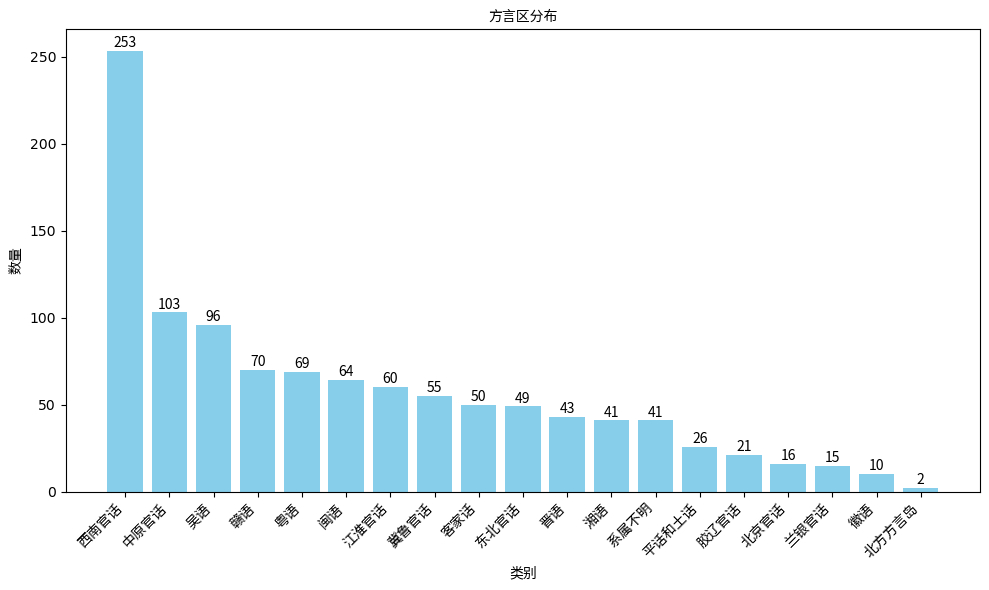

不同类别及其数量：
西南官话: 253
中原官话: 103
吴语: 96
赣语: 70
粤语: 69
闽语: 64
江淮官话: 60
冀鲁官话: 55
客家话: 50
东北官话: 49
晋语: 43
湘语: 41
系属不明: 41
平话和土话: 26
胶辽官话: 21
北京官话: 16
兰银官话: 15
徽语: 10
北方方言岛: 2


In [1]:
from utils import count_and_plot_categories
from load import load_feats
import numpy as np

areas = load_feats(name='Data4', type='info')['areas']
my_font_path = 'utils/NotoSansSC-Regular.ttf'
categories, counts = count_and_plot_categories(np.array(areas), font_path=my_font_path, title="方言区分布")
if categories is not None:
    print("不同类别及其数量：")
    for cat, count in zip(categories, counts):
        print(f"{cat}: {count}")

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

def feature_reduction(data, method='pca', n_components=2, **kwargs):
    """
    使用指定的降维方法对数据进行降维。

    Args:
        data (np.ndarray): 输入数据，形状为 (n_samples, n_features)。
        method (str): 降维方法，可选 'pca', 'tsne', 'isomap'。默认为 'pca'。
        n_components (int): 目标维度。默认为 2。
        **kwargs: 传递给对应降维方法的额外参数。

    Returns:
        np.ndarray: 降维后的数据，形状为 (n_samples, n_components)。
                    如果方法不可用或发生错误，返回 None。
    """
    valid_methods = ['pca', 'tsne', 'isomap']
    method = method.lower() # 转换为小写以忽略大小写

    if method not in valid_methods:
        print(f"Error: Invalid method '{method}'. Available methods are: {', '.join(valid_methods)}")
        return None

    print(f"Applying {method.upper()} dimensionality reduction to {n_components} components...")

    try:
        if method == 'pca':
            model = PCA(n_components=n_components, **kwargs)
            reduced_data = model.fit_transform(data)
            print("PCA applied successfully.")
            return reduced_data

        elif method == 'tsne':
            # t-SNE 通常用于可视化，不适用于高维输出
            if n_components > 3:
                 print("Warning: t-SNE is typically used for 2 or 3 dimensions for visualization.")
            model = TSNE(n_components=n_components, **kwargs)
            reduced_data = model.fit_transform(data)
            print("t-SNE applied successfully.")
            return reduced_data

        elif method == 'isomap':
            model = Isomap(n_components=n_components, **kwargs)
            reduced_data = model.fit_transform(data)
            print("Isomap applied successfully.")
            return reduced_data

    except Exception as e:
        print(f"Error applying {method.upper()}: {e}")
        return None

In [ ]:
distance = load_feats(name='Data4', features=['overall_distance'])['overall_distance']
distance_pca = feature_reduction(distance, method='pca', n_components=2)

In [ ]:
def plot_2d_embedding_improved(X,                   # 2D 数据 (n_samples, 2)
                               y_labels,            # 每个点的标签 (n_samples,)
                               plot_title,          # 图表标题 (字符串)
                               save_path,           # 保存图片的完整路径 (e.g., './plots/pca.png')
                               label_title="区域/标签", # 图例标题
                               font_prop=None,      # 传递获取到的 FontProperties 对象
                               use_adjust_text=True # 是否使用 adjustText
                              ):
    """
    生成并保存降维结果的 2D 散点图 (改进版，支持中文)。
    """
    print(f"\n--- Plotting: {plot_title} ---")
    # --- 输入验证 ---
    if X is None:
        print("Error: Input data 'X' is None. Skipping plot.")
        return
    if not isinstance(X, np.ndarray) or X.ndim != 2 or X.shape[1] != 2:
        print(f"Error: Input data 'X' must be a 2D NumPy array (shape={X.shape}). Skipping plot.")
        return
    if y_labels is None or len(y_labels) != X.shape[0]:
        print(f"Error: 'y_labels' is None or its length ({len(y_labels) if y_labels is not None else 'None'}) does not match number of data points ({X.shape[0]}). Skipping plot.")
        return

    # --- 确保保存目录存在 ---
    save_dir = os.path.dirname(save_path)
    if save_dir and not os.path.exists(save_dir):
        try:
            os.makedirs(save_dir)
            print(f"Created save directory: {save_dir}")
        except OSError as e:
            print(f"Error creating save directory {save_dir}: {e}. Cannot save plot.")
            return

    # --- 绘图设置 ---
    plt.figure(figsize=(12, 9))
    ax = plt.gca() # Get current axes

    unique_labels = np.unique(y_labels)
    num_unique_labels = len(unique_labels)

    # --- 获取颜色映射 (修正 get_cmap 用法) ---
    try:
        # 使用 plt.get_cmap 或 matplotlib.colormaps.get_cmap
        cmap = plt.get_cmap('tab20', num_unique_labels)
    except (ValueError, TypeError) as e: # 处理找不到 Colormap 或 num_labels 参数不支持的情况
        print(f"Warning: Colormap 'tab20' issue ({e}). Falling back to 'viridis'.")
        try:
             cmap = plt.get_cmap('viridis', num_unique_labels) # 备用方案
        except TypeError: # 如果 viridis 也不支持 num_unique_labels
             cmap = plt.get_cmap('viridis')
             print("Warning: Fallback 'viridis' also doesn't support num_unique_labels argument. Using default colors.")

    markers = ['o', 's', '^', 'P', '*', 'X', 'D', 'v', '<', '>'] * (num_unique_labels // 10 + 1)

    handles = [] # 用于图例
    texts = []   # 用于 adjustText

    # --- 绘制散点和文本标签 ---
    for i, name in enumerate(unique_labels):
        indices = np.where(y_labels == name)[0]
        # 获取颜色时进行归一化处理
        color_val = i / max(1, num_unique_labels - 1) if num_unique_labels > 1 else 0.5
        try:
            color = cmap(color_val)
        except TypeError: # 如果 cmap 不支持 num_unique_labels, 它可能返回 Colormap 对象而不是函数
             # 使用 Colormap 对象的 colors 列表
             color = cmap.colors[i % len(cmap.colors)]
             if i >= len(cmap.colors):
                  print(f"Warning: Not enough distinct colors in chosen colormap ({len(cmap.colors)}). Colors will repeat for label '{name}'.")

        marker = markers[i % len(markers)]

        # 绘制散点
        scatter = ax.scatter(X[indices, 0], X[indices, 1],
                           color=color, marker=marker, label=str(name), # 确保标签是字符串
                           s=60, alpha=0.8, edgecolors='w', linewidth=0.5)
        handles.append(scatter) # 添加到图例句柄

        # 为每个点添加文本标签 (使用 font_prop)
        for idx in indices:
            label_text = str(y_labels[idx]) # 确保标签是字符串
            text_args = {'fontsize': 9, 'alpha': 0.8}
            if font_prop:
                 text_args['fontproperties'] = font_prop # 应用字体属性

            texts.append(ax.text(X[idx, 0], X[idx, 1], label_text, **text_args))


    # --- 使用 adjustText 防止标签重叠 ---
    should_adjust = use_adjust_text and adjust_text_available and texts
    if should_adjust:
         print("Applying adjust_text to prevent label overlap...")
         try:
             adjust_text(texts, ax=ax,
                         arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.6),
                         force_text=(0.2, 0.5), force_points=(0.1, 0.2),
                         expand_points=(1.1, 1.1))
             print("adjust_text applied.")
         except Exception as e:
             print(f"Error during adjust_text: {e}")
    elif use_adjust_text and not adjust_text_available:
         print("adjustText not available or not installed, labels may overlap.")
    elif not texts:
         print("No text labels generated.")

    # --- 设置标题、轴标签和网格 (使用 font_prop) ---
    title_props = {'fontsize': 16, 'fontweight': 'bold'}
    label_props = {'fontsize': 12}
    if font_prop:
        title_props['fontproperties'] = font_prop
        label_props['fontproperties'] = font_prop

    ax.set_title(plot_title, **title_props)
    ax.set_xlabel('Component 1', **label_props)
    ax.set_ylabel('Component 2', **label_props)
    ax.grid(True, linestyle='--', alpha=0.5)

    # --- 创建图例 (使用 font_prop) ---
    legend_labels = [str(name) for name in unique_labels] # 确保图例标签是字符串
    ncol = 1 if num_unique_labels <= 10 else 2
    legend_kwargs = {'loc': 'upper left', 'bbox_to_anchor': (1.03, 1.0),
                     'title': label_title, 'ncol': ncol,
                     'fontsize': 10, 'markerscale': 1.0}
    if font_prop:
        legend_kwargs['prop'] = font_prop # 应用于图例条目
        legend_title_font = font_prop.copy()
        legend_title_font.set_size(12) # 设置图例标题大小
        legend_kwargs['title_fontproperties'] = legend_title_font

    # 仅当有句柄时才创建图例，避免无数据时报错
    if handles:
        ax.legend(handles=handles, labels=legend_labels, **legend_kwargs)
        # --- 调整布局以适应图例 ---
        plt.subplots_adjust(right=0.78 if ncol == 1 else 0.72) # 根据图例列数微调
    else:
        print("Warning: No data points plotted, skipping legend creation.")


    # --- 保存图像 ---
    try:
         plt.savefig(save_path, dpi=300, bbox_inches='tight')
         print(f"Saved plot to {save_path}")
    except Exception as e:
         print(f"Error saving plot {save_path}: {e}")
    finally:
        plt.close() # 确保图形关闭，释放内存

# --- 使用改进的函数绘图 ---
plot_2d_embedding_improved(X_fake,
                            y_labels_fake,
                            "城市分布模拟 (中文标签)", # <--- 中文标题
                            "./plot_chinese_labels_final.png", # 新文件名
                            label_title="城市名称",     # <--- 中文图例标题
                            font_prop=font_prop,       # <--- 传递字体对象
                            use_adjust_text=True)      # 使用 adjustText

plot_2d_embedding_improved(X_fake,
                            y_labels_fake_numeric,
                            "分布模拟 (数字标签)",
                            "./plot_numeric_labels_final.png", # 新文件名
                            label_title="所属类别",     # <--- 中文图例标题
                            font_prop=font_prop,       # <--- 传递字体对象
                            use_adjust_text=False)     # 禁用 adjustText

print("\n--- Plotting finished ---")

In [ ]:
coords = load_feats(name='Data4', type='info')['coords']
print(coords)